<a href="https://colab.research.google.com/github/robosquiggles/2156_Demos/blob/main/2_155_Fall_24_Demo_8_Part_1_Generative_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2.155/6 Demo 8: Unsupervised Learning - Generative Models & Constrastive Learning - Part 1: Generative Models

<div style="font-size: small;">
License Terms:  
These Python demos are licensed under a <a href="https://creativecommons.org/licenses/by-nc-nd/4.0/">Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International License</a>. They are intended for educational use only in Class 2.155/2.156: AI and ML for Engineering Design at MIT. You may not share or distribute them publicly, use them for commercial purposes, or provide them to industry or other entities without permission from the instructor (faez@mit.edu).
</div>

---

Table of Contents:

Installs and Imports
Setting up data

**Part 1. Generative Models**

  A: Variational Auto-Encoders (VAE)

  B: Diffusion Models

Part 2. Contrastive Learning

  A: Baseline Classifiers

  B: Contrastive Learning: Sim-CLR

  C: Sim-CLR Downline Classifier

### **Notebook Description**
In this notebook, we will implement generative models.

### **Imports**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

from tqdm.autonotebook import tqdm, trange

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import pandas as pd
from sklearn import preprocessing
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from google.colab import drive
from pathlib import Path
import sklearn
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time
import os
from tqdm.autonotebook import tqdm

from tqdm.auto import trange, tqdm

from torch.utils.data import Dataset, DataLoader


<ipython-input-1-c5a296808f86>:19: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


### **Helper Functions**

In [2]:
def plotcomparison(preds, actual, indices):
    fig = plt.figure(figsize=(25, 15))
    for i in range(16):
        if i % 2 == 1:
            idx = indices[i//2]
            plt.subplot(4, 4, i + 1)
            plt.imshow(np.squeeze(preds[i // 2]), cmap="gray")

            # Convert numpy arrays to PyTorch tensors
            preds_tensor = torch.tensor(preds[i // 2]).unsqueeze(0)
            actual_tensor = torch.tensor(actual[i // 2]).unsqueeze(0)
            plt.title("Model " + str(idx) + " Generated", fontsize=20)
            plt.axis('off')
        else:
            idx = indices[i//2]
            plt.subplot(4, 4, i + 1)
            plt.imshow(np.squeeze(actual[i // 2]), cmap="gray")
            plt.title("Model " + str(idx) + " Ground Truth", fontsize=20)
            plt.axis('off')

def plot_samples(preds):
    fig = plt.figure(figsize=(25, 15))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(np.squeeze(preds[i]), cmap="gray")
        plt.axis('off')

## Part 1: Generative Models

In this section we will discuss generative models. For this demo we will be looking at the bike data we used in Demo 6. The idea behind generative models can be summarized in the figure below:

![image](https://media2.giphy.com/media/v1.Y2lkPTc5MGI3NjExZTljNHB3NzA2bjcwdWs3d3BxdGE0ZmlkajR1c2ZrdTh3MHBpbmVhZCZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/bbgToNQcTJfD9ZD6kS/giphy.gif)

Generative models effectively try learn a mapping between a known distribution that we can sample from to our data distribution!

First let's download the data:

In [3]:
url = 'https://raw.githubusercontent.com/Lyleregenwetter/2.s997-Demo-Materials/main/Classification/BIKED_processed.csv'
params = pd.read_csv(url, index_col=0)
url='https://raw.githubusercontent.com/Lyleregenwetter/2.s997-Demo-Materials/main/Classification/Bikestyle.csv'
classes = pd.read_csv(url, index_col=0)

image_dir = 'https://raw.githubusercontent.com/Lyleregenwetter/2.s997-Demo-Materials/main/BIKED_Im/'
image_batches=[]
for i in trange(12): # We split the images into 12 files to bypass github limits.
    filename = f"images_{i}.npy"
    file_url = image_dir + filename
    !wget -q {file_url}
    image_batches.append(np.load(filename))
images = np.vstack(image_batches) # We concatenate here

  0%|          | 0/12 [00:00<?, ?it/s]

Like always we will delve into the data structure a bit and visalize the data:

In [5]:
print(f'Shape of parameter data: {params.shape}')
print(f'Shape of image data: {images.shape}')
print(f'Shape of class data: {classes.shape}')

Shape of parameter data: (4512, 2401)
Shape of image data: (4512, 120, 260)
Shape of class data: (4512, 1)


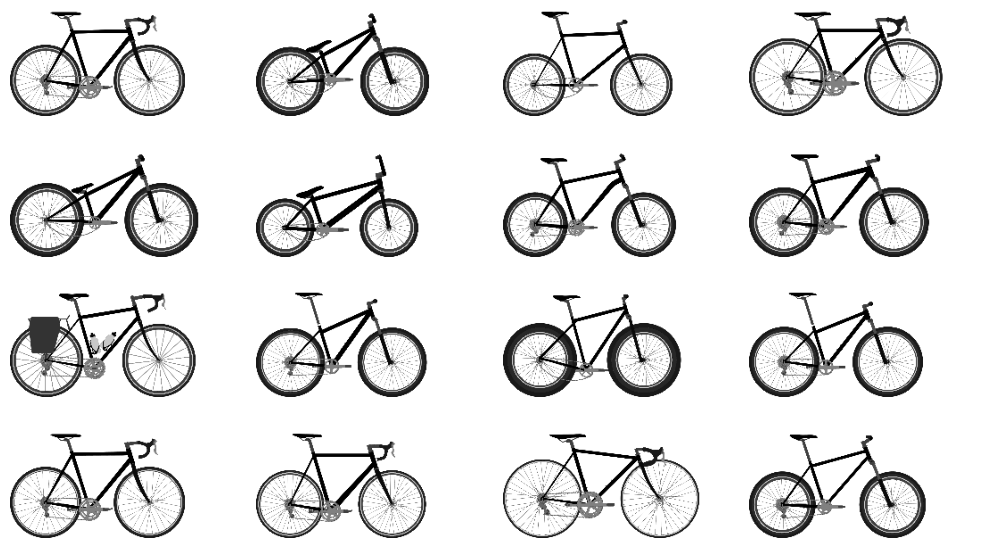

In [6]:
fig, axes = plt.subplots(4, 4, figsize=(10, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap='gray') # The images are single-channel (grayscale)
    ax.axis('off')
plt.tight_layout()
plt.show()

Now we will process the data to get it ready for pytorch.

In [7]:
min_max_scaler = preprocessing.MinMaxScaler()
params_scaled = min_max_scaler.fit_transform(params.values)
params_scaled = pd.DataFrame(params_scaled, columns=params.columns,index=params.index.values).astype('float32')

le = preprocessing.LabelEncoder()
le.fit(classes)
classes_num=le.transform(classes)
print(classes_num)

randomst=42
param_train, param_val, image_train, image_val, class_train, class_val = train_test_split(params_scaled, images, classes_num, test_size=0.2, random_state =randomst)
# keep the dataframe for later use in visualization
param_pd_train, param_val_pd = param_train, param_val

param_train, param_val = param_train.to_numpy(), param_val.to_numpy()
dim_params = param_train.shape[1]
image_train = np.expand_dims(image_train, axis=1).astype('float32')
image_val = np.expand_dims(image_val, axis=1).astype('float32')

dim_images=np.shape(image_train[1])
dim_classes=19


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[14  7 13 ... 14 14 14]


For this section of the demo we will focus on images and train both a VAE and a diffusion model to generative bike images and we will explore how each of these approaches play out.

### **Image VAE**
We previously discussed variational autoencoders as a tool for dimensionality reduction or embeddings. As it turns out, VAEs can be used as a generative model too! We do this by randomly sampling points in the latent space and translating them into generated samples.

To review: In VAEs we have an encoder which takes the data as input and outputs a latent code (distribution in the form of mean and variance for each dimension of the latent code), which is then fed to a decoder which trys to reconstruct the original data. In VAEs, we simultaniously train the decoder to reconstruct the data through a reconstruction loss, which is often the euclidian distance between the original data and the reconstructured data and train the encoder to output standard normal distributions in the latent space (This is our known distribution which we can sample from later). When used in a generative setting, we first train VAE, but once trained we will only use the decoder, which acts as our generator.  

In [8]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        self.latent_dim = latent_dim
        self.conv1 = nn.Conv2d(1, 32, 3, stride=(2, 2))
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, 3, stride=(2, 2))
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, 3, stride=(2, 2))
        self.bn3 = nn.BatchNorm2d(128)

        self.fc = nn.Linear(128 * 14 * 31, 2 * self.latent_dim)

        # We are using dropout as a regularization
        self.dropout = nn.Dropout(0.1)
        self.leaky_relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)

        x = torch.flatten(x, 1)

        x = self.fc(x)

        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        self.latent_dim = latent_dim
        self.fc = nn.Linear(self.latent_dim, 30 * 65 * 32)
        self.bn1 = nn.BatchNorm1d(30 * 65 * 32)
        # We are using leaky relu instead of the previoysly shown relu as activation
        self.leaky_relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.1)

        # de convolution layer
        self.deconv1 = nn.ConvTranspose2d(32, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        # de convolution layer
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        # de convolution layer
        self.deconv3 = nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = self.bn1(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)

        x = x.view(-1, 32, 30, 65)

        x = self.deconv1(x)
        x = self.bn2(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)

        x = self.deconv2(x)
        x = self.bn3(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)

        x = self.deconv3(x)

        return x

class ImageVAE(nn.Module):
    def __init__(self, imdims, latent_dim):
        super().__init__()
        self.dim_x = imdims
        self.latent_dim = latent_dim

        self.encoder_net = Encoder(latent_dim=self.latent_dim)
        self.decoder_net = Decoder(latent_dim=self.latent_dim)
        self.fc_mean = nn.Linear(2 * self.latent_dim, latent_dim)
        self.fc_var = nn.Linear(2 * self.latent_dim, latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
      h = self.encoder_net(x)
      mu, logvar = self.fc_mean(h), self.fc_var(h)
      z = self.reparameterize(mu, logvar)
      return z, mu, logvar

    def decode(self, x):
      return torch.sigmoid(self.decoder_net(x))

    def forward(self, x):
        # Encoder
        z, mu, logvar = self.encode(x)
        # Decoder
        output = self.decode(z)
        return output, mu, logvar

    def reconstruct(self, x):
        h = self.encoder_net(x)
        mu, logvar = self.fc_mean(h), self.fc_var(h)
        output = self.decode(mu)

        return output

def vae_loss(recon_x, x, mu, logvar):
    # BCE = nn.BCELoss(reduction='sum')(torch.sigmoid(recon_x), x)
    recon_loss = nn.BCELoss(reduction='mean')(recon_x, x)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + KLD * 0.005

def train_vae_model(train_loader, model, optimizer,num_epochs, device):
  model = model.to(device)
  model.train()

  for epoch in range(num_epochs):
    logs = {}
    running_loss = 0.0
    prog = tqdm(enumerate(train_loader), total=len(train_loader))
    n = 0
    for batch_idx, (data, _) in prog:
      data = data.to(device)

      optimizer.zero_grad()
      output, mu, logvar = model(data)
      loss = vae_loss(output, data, mu, logvar)
      loss.backward()
      optimizer.step()
      running_loss += loss.detach() * data.size(0)
      n += data.size(0)

      prog.set_description(f"Epoch {epoch+1}/{num_epochs}")
      prog.set_postfix_str(f"Loss: {loss.item():.7f} | Running Loss: {running_loss/n:.7f}")

    epoch_loss = running_loss / len(train_loader)
    logs['loss'] = epoch_loss.item()


def pred_image(model, image_val):
  model.eval()  # Set the model to evaluation mode
  eval_images = torch.tensor(image_val[:8]).to(device)
  pred_images = model.reconstruct(eval_images)
  return pred_images.detach().cpu().numpy()

In [9]:
def torch_dataset(x, y, batch_size, shuffle=True):
  x, y = torch.tensor(x), torch.tensor(y)

  data = TensorDataset(x, y)
  dataloader = DataLoader(data, batch_size=batch_size, shuffle=shuffle)

  return dataloader

# define hyperparameters
batch_size = 32
learn_rate = 1e-3
num_epochs = 20
latent_dim = 32

# set up device: cpu or gpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# create data loader for feeding into the training loop
img_train_loader = torch_dataset(x=image_train, y=class_train,
                             batch_size=batch_size, shuffle=True)

# create data loader for feeding into the evaluation loop
img_val_loader = torch_dataset(x=image_val, y=class_val,
                           batch_size=batch_size, shuffle=False)

#instantiate model, optimizer and loss/criterion
model = ImageVAE(dim_images, latent_dim)
optimizer = optim.AdamW(model.parameters(), lr=learn_rate)

# train your model
train_vae_model(img_train_loader, model, optimizer, num_epochs//2, device)

# train with lower learning rate (This helps )
optimizer = optim.AdamW(model.parameters(), lr=learn_rate//10)
train_vae_model(img_train_loader, model, optimizer, num_epochs//2, device)

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

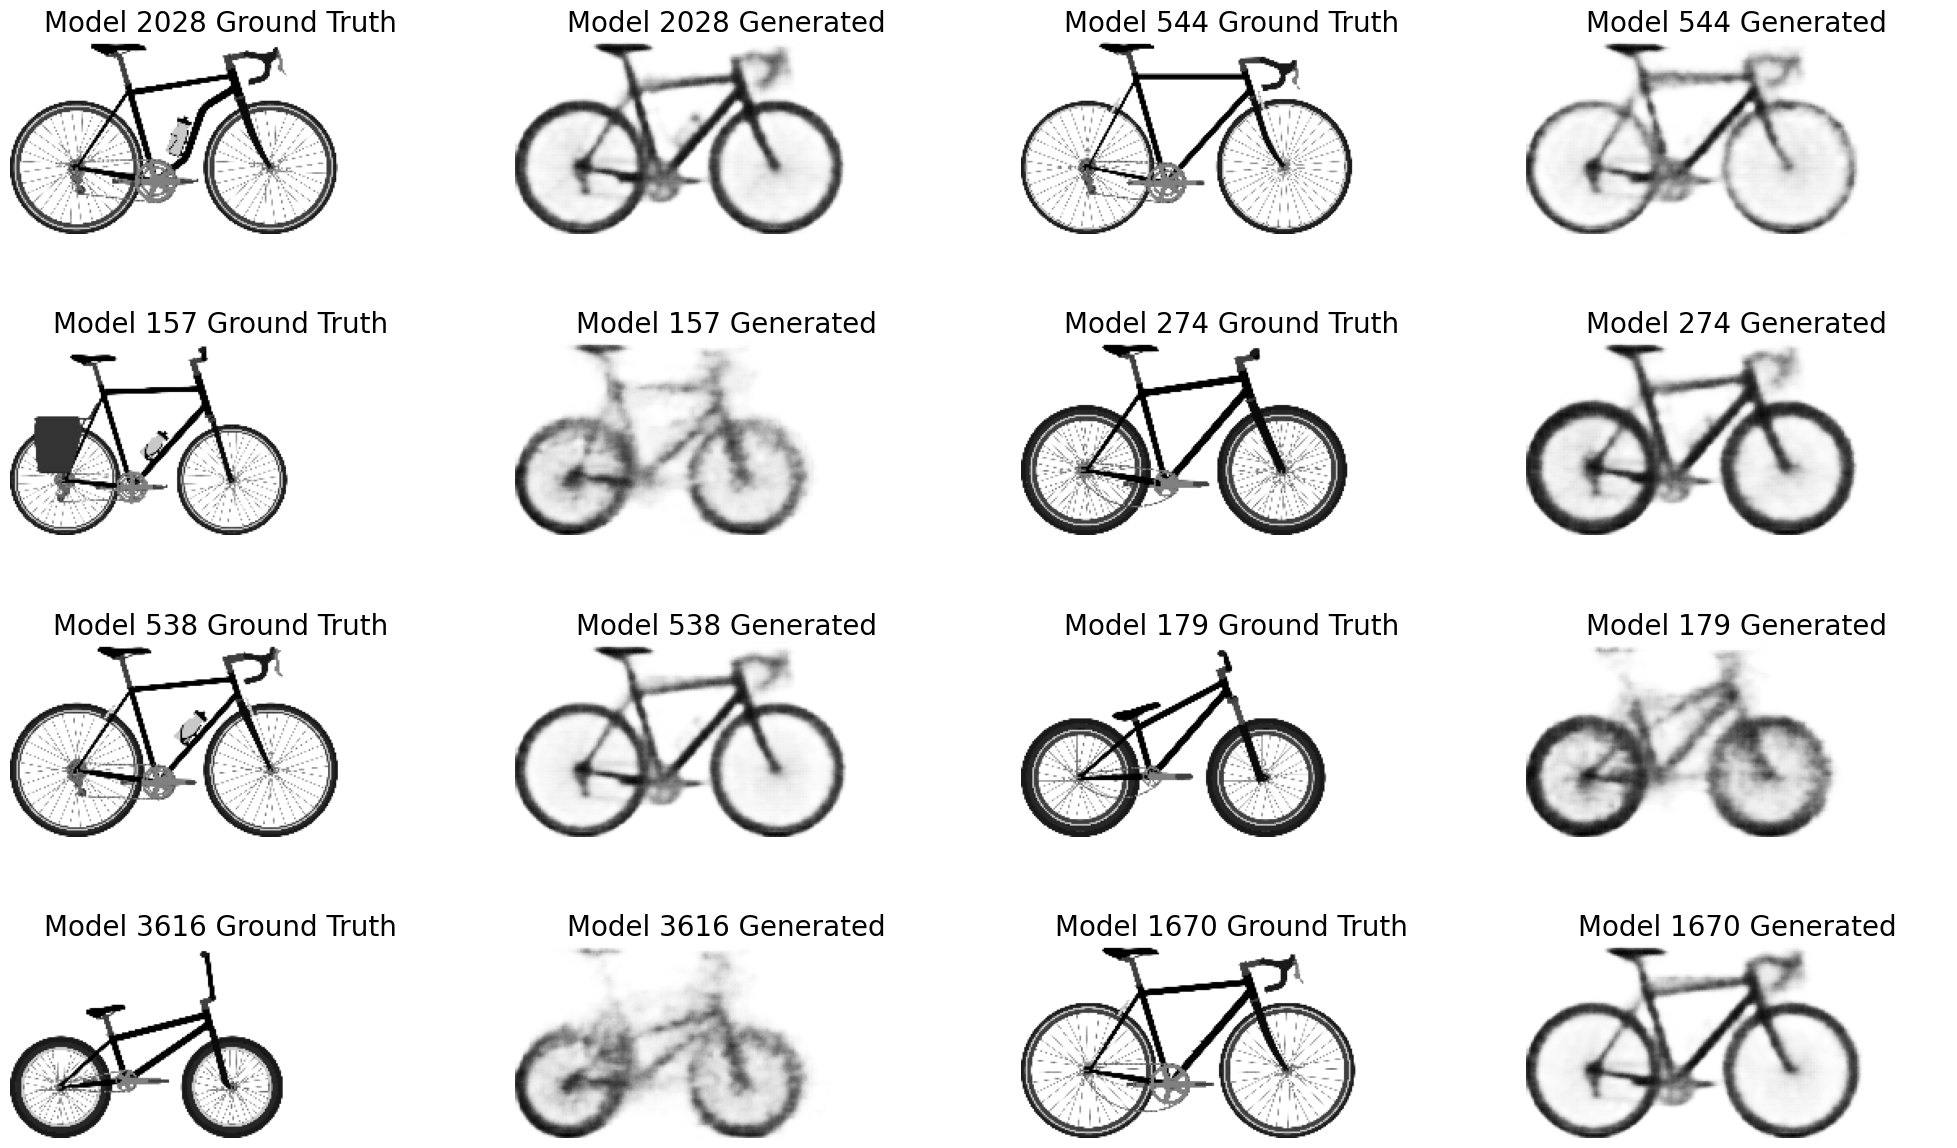

In [10]:
preds = pred_image(model, image_val)
plotcomparison(preds, image_val[:8], param_val_pd.index[:8])

These images are not super nice but you should be able to get the idea. Now let's sample from the latent space and generate some new samples.

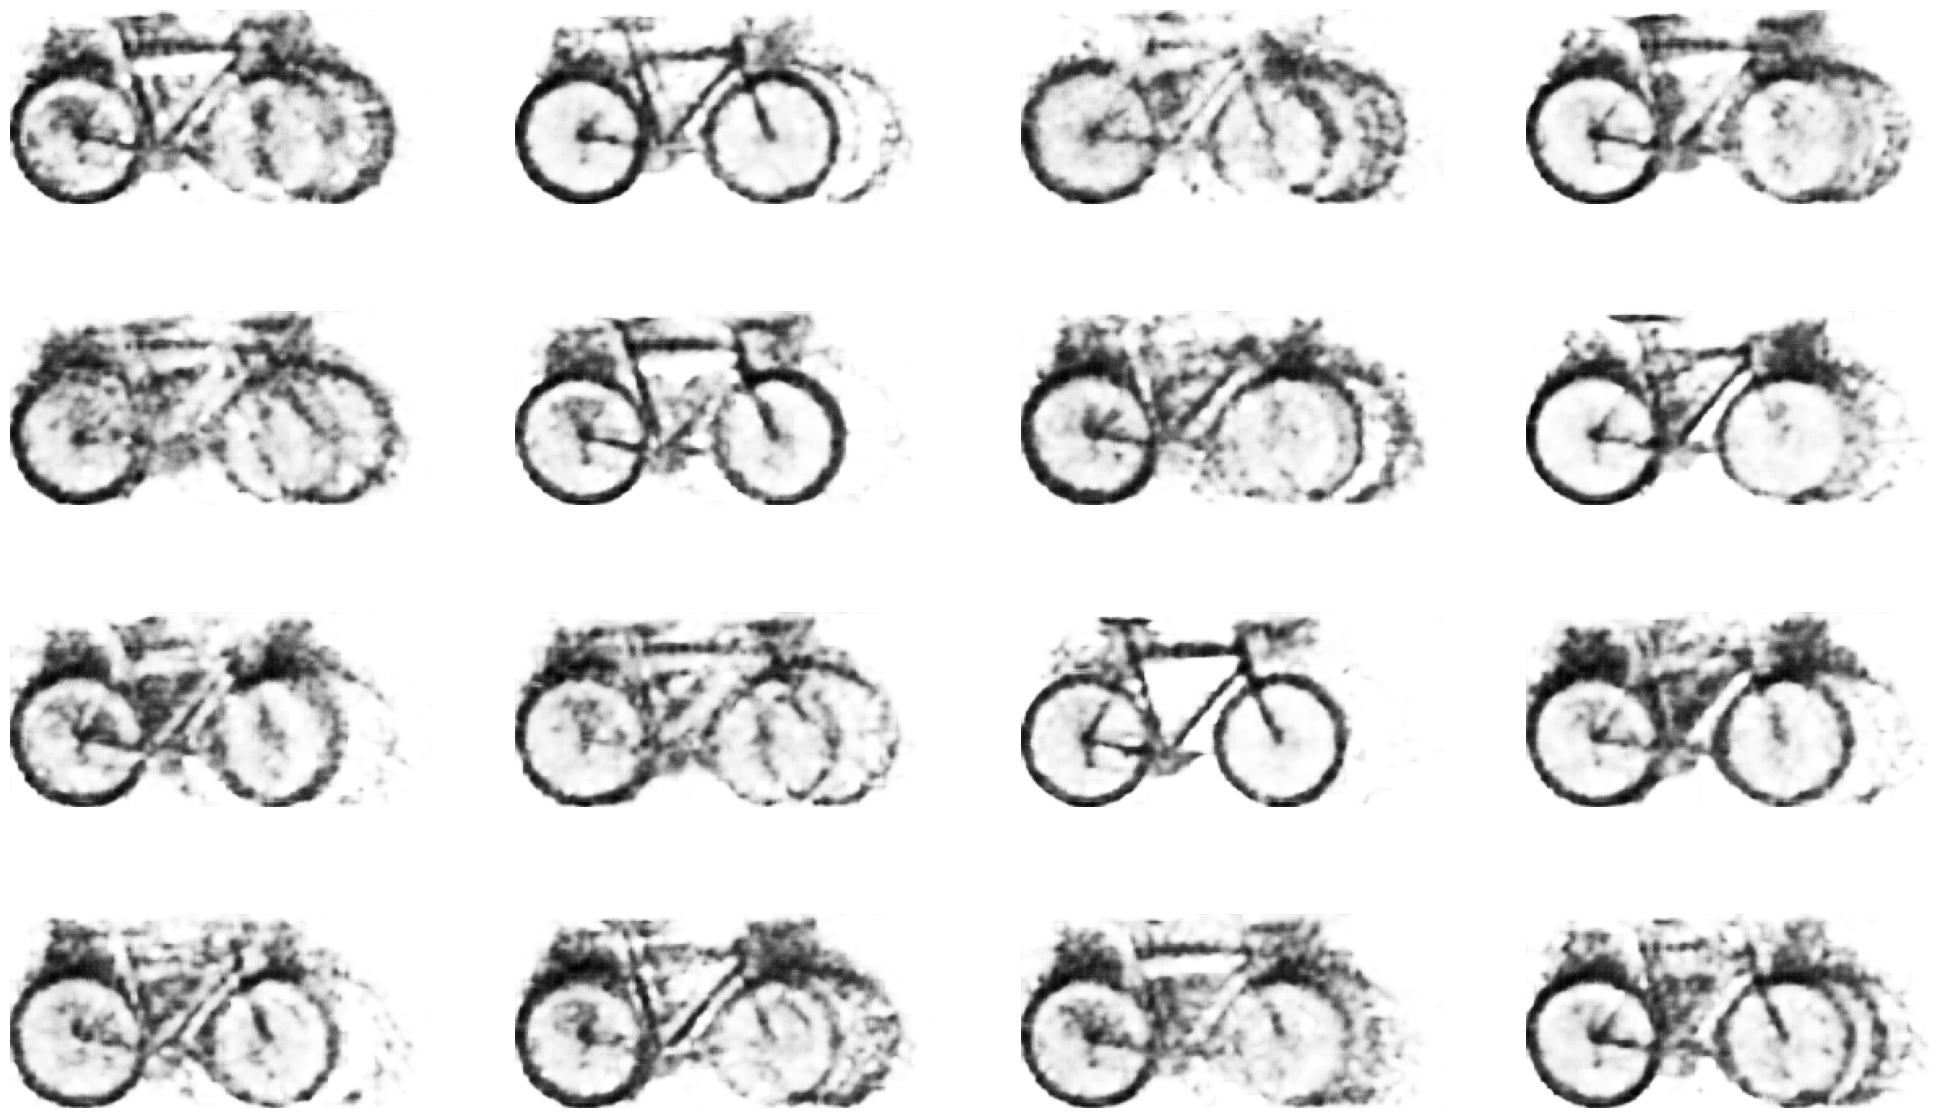

In [11]:
z = torch.randn([16,latent_dim])
z = z.to(device)
new_images = model.decode(z)

plot_samples(new_images.detach().cpu().numpy())

Note that we sample randomly here so we are generating these images from scratch and not reconstructing them. Although these images are high quality with a larger model and more advanced architecture we can get very nice images without having to reconstruct them. Despite this VAEs are still somewhat biased towards reconstruction. Next we will talk about a different architecture for image generation which is designed purely for image generation and not recosntruction.

### **Diffusion Model: Denoising diffusion probabilistic model (DDPM)**

In this demo, we will train a DDPM model that was originally proposed in [this paper](https://arxiv.org/abs/2006.11239). DDPM is an improved version of the first diffusion model proposed in [this paper](https://arxiv.org/abs/1503.03585). We will keep the discussion fairly high-level but feel free to dive deeper if you are interested.

Before moving forward we will need some helper functions:

In [12]:
def show_images(data, num_samples=5, cols=5):
  """
  Visualize some of the images form the dataset
  """
  plt.figure(figsize=(15,15))
  for i, img in enumerate(data):
      if i == num_samples:
          break
      plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
      plt.imshow(img, cmap='gray')
  plt.show()

def downsample_images(images, down_size=4):
  """
  Downsample each image by 1/4th of the original image size
  """
  new_shape = (int(images.shape[0]), int(images.shape[1]/down_size),
               int(images.shape[2]/down_size))
  new_data = np.zeros(new_shape)

  for i in range(images.shape[0]):
      new_data[i] = cv2.resize(images[i], (65, 30))
  return new_data


def print_message(messages):
  # Find the message with maximum length to set box width
  max_len = max(len(msg) for msg in messages)

  # Create the box
  border = '+' + '-' * (max_len + 2) + '+'
  print(border)
  for msg in messages:
      # Center the message and print
      print('| ' + msg.center(max_len) + ' |')
  print(border)



Let's take a look at the downsampled images and compare them with the original images.

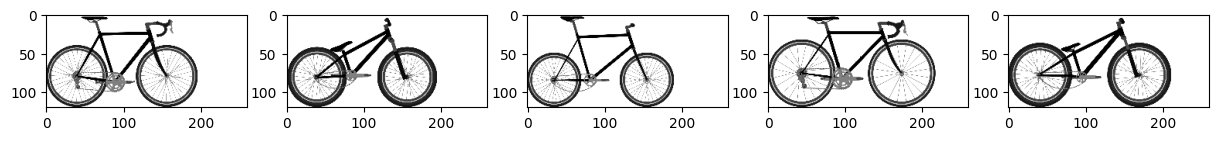

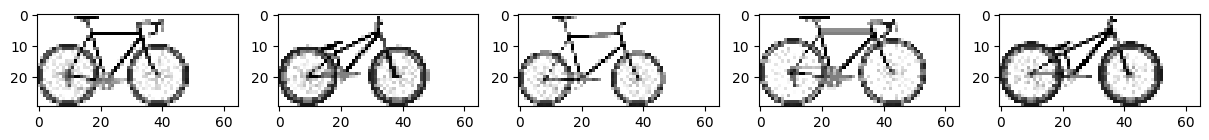

+----------------------------------------+
| image dataset shape: (4512, 1, 30, 65) |
|               channel: 1               |
|        each image size: 30 x 65        |
+----------------------------------------+


In [13]:
original_images = images
down_images = downsample_images(original_images)

show_images(original_images)
show_images(down_images)

data = np.expand_dims(down_images, axis=1)

messages = [
    f'image dataset shape: {data.shape}',
    f'channel: {data.shape[1]}',
    f'each image size: {data.shape[2]} x {data.shape[3]}'
]

print_message(messages)

# create dataset split
data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)

class BikeDataset(Dataset):
    def __init__(self, x):
        self.x = torch.tensor(x)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx]

def torch_dataloader(train, test, batch_size=32):
    train_dataset, test_dataset = BikeDataset(train), BikeDataset(test)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_dataloader, test_dataloader


train_loader, test_loader = torch_dataloader(train=data_train, test=data_test)

#### **What is a diffusion generative model?**
Ideally, we would like to learn the underlying probability distribution of the training dataset so we can produce data by sampling from this distribution. VAEs are likelihood based models but they can perform poorly in practice. Diffusion model is a great addition to the likelihood based generative model family.

So, what is a diffusion model?
A diffusion model learns the by a very special way. Intuitively, the idea is to completely destroy the each data with zero mean Gaussian noise and then learn the process that can reconstruct the data from this noise. Diffusion model does this in sequence of operations. Instead of destroring the image with random noise in a single step, diffusion model does so in many sequential steps. Typically the number of steps are around 1000. At each step, we add a small amount of noise to the data. This process is done by a **variance scheduler, $\beta$**.

Typically, $\beta$ is linearly increased in small amounts. For example, the original paper proposed $\beta$ to linearly increase from $0.0001$ to $0.02$. Let's write the helper functions that can help us to this.  

In [15]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return np.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

#### **Forward process**

As you can imagine, there are two steps in a diffusion model.
1.   Forward process: add noise sequentially to each data/image
2.   Reverse proess: remove noise from each data/image to learn the noise distribution for this dataset


Fortunately, we do not really need to add noise sequentially. This is because there is a closed form solution. With a little bit of math, we can derive a formulation for this. We will not go into details, but rest assured that the code we provide takes care of this. Let's visualize some of the samples from our bike dataset and see how noise is added sequentially to destroy each image.

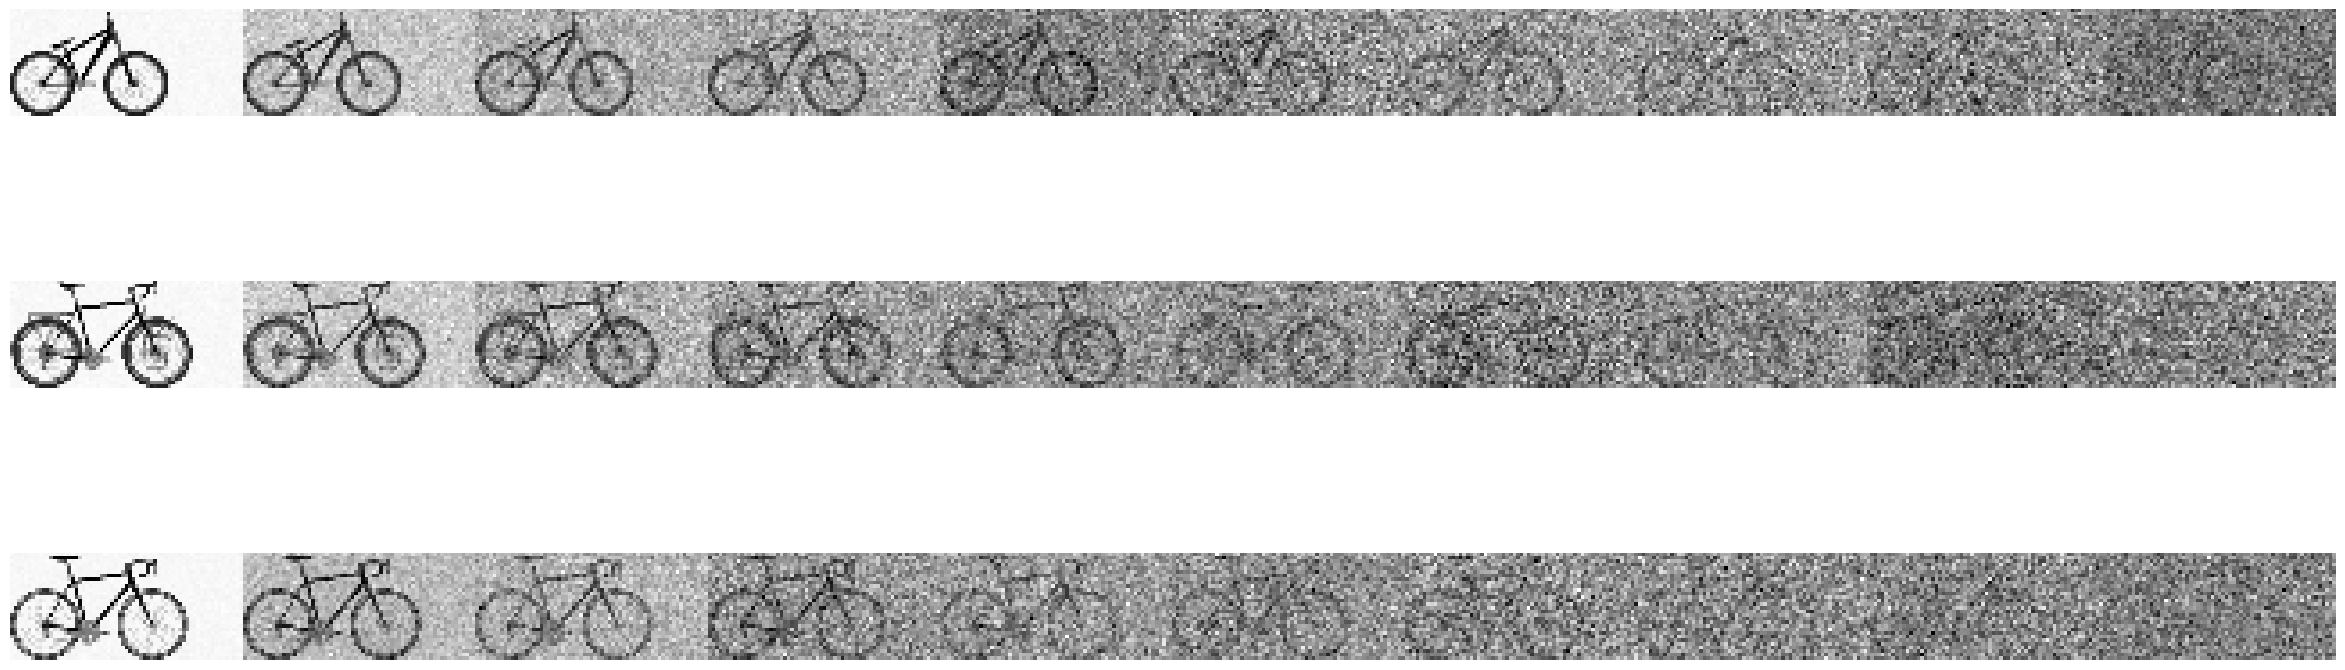

In [16]:
def closed_form_solution(T, betas):
  # Pre-calculate different terms for closed form
  alphas = 1. - betas
  alphas = torch.tensor(alphas)
  alphas_cumprod = torch.cumprod(alphas, axis=0)
  alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
  sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
  sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
  sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

  return sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod


def forward_diffusion_sample(x_0, t, T, betas, device="cpu"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    x_0: (batch_size, 1, 30, 65)

    """
    # create noise tensor
    noise = torch.randn_like(x_0)

    # for calculation purpose take everything to the gpu or cpu --> same device
    noise, t = noise.to(device), t.to(device)

    #
    sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod = closed_form_solution(T, betas)

    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )

    # mean
    forward_mean = sqrt_alphas_cumprod_t.to(device) * x_0

    # variance
    forward_variance = sqrt_one_minus_alphas_cumprod_t

    # reparameterization
    sample = forward_mean + forward_variance * noise

    return sample, noise


def viz_forward_diffusion(batch, betas, T=300, num_images=5, num_diffusion=3, device='cpu'):
  stepsize = int(T/num_images)

  samples = []
  for idx in range(0, T, stepsize):
      t = torch.Tensor([idx]).type(torch.int64)
      img, noise = forward_diffusion_sample(batch, t, T, betas, device=device)
      samples.append(img)
  samples = torch.cat(samples, dim=0)


  batch_size = img.shape[0]
  indices = torch.tensor([k for k in range(samples.shape[0])])
  all_images = []
  m = 0
  for k in range(num_diffusion):
    all_images.append(torch.index_select(samples, 0, indices[m::batch_size]))
    m += 1

  ncols = num_images
  nrows = num_diffusion
  plt.figure(figsize=(ncols*nrows, ncols))
  plot_id = 0
  nrows, ncols = len(all_images), all_images[0].shape[0]

  for img in all_images:
    for idx in range(ncols):
      plt.subplot(nrows, ncols, plot_id + 1)
      plt.imshow(img[idx].squeeze(), cmap='gray')
      plt.axis('off')
      plot_id += 1

  plt.subplots_adjust(wspace=0)
  plt.show()


def test_forward_diffusion():
  # Simulate forward diffusion
  batch = next(iter(train_loader))

  # Define beta schedule
  T = 100  # total diffusion steps
  betas = linear_beta_schedule(timesteps=T)
  viz_forward_diffusion(batch, betas, T=T, num_images=10, num_diffusion=3)

test_forward_diffusion()

#### **Reverse process:**
For the reverse process we will use a neural network to learn the noise distribution. The DDPM paper utilized a special type of neural network called the 'U-Net' that uses convolutional layers in a specific way. You can probably guess at this point that the shape of the neural network is 'U-like'. In fact, this was proposed in [this paper](https://arxiv.org/abs/1505.04597) and looks like the following: 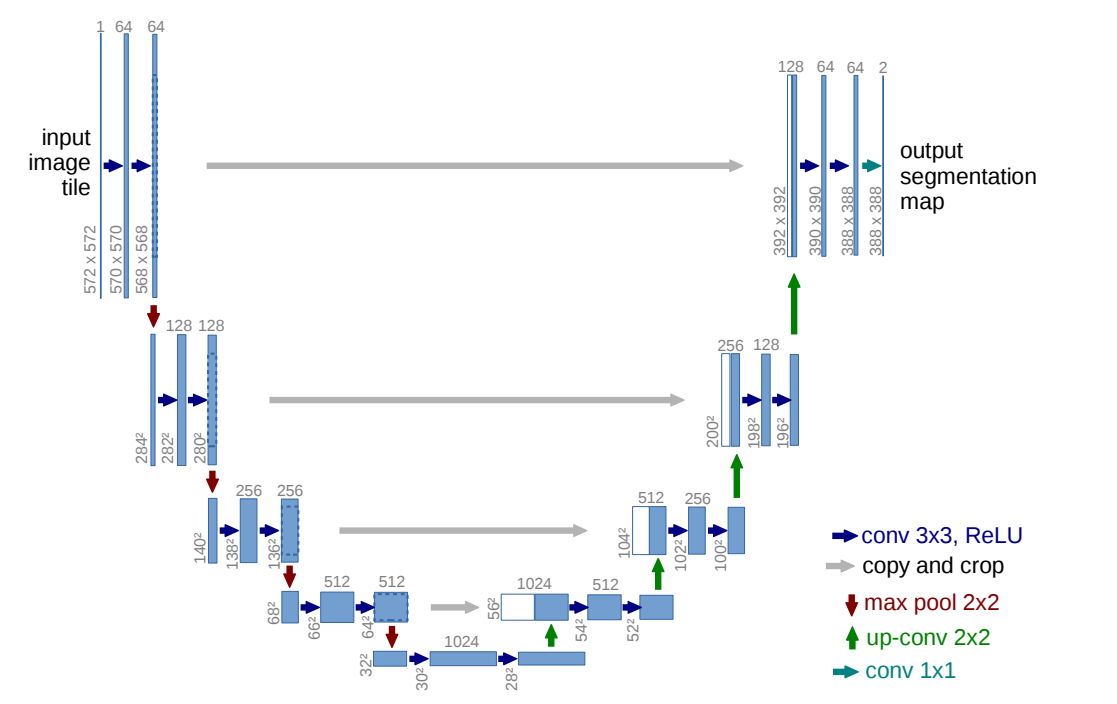


* What about the timestep information?

Notice that the neural network does not inherently have any knowledge of the timestep. Dince we want the network to be aware of what stage of the diffusion process it is at, we must add this to the model. This is done by the famous transformer paper method for sequential data. We basically adding an additional embedding tensor to each data that keeps track of each timestep. Do not worry if you find it difficult. We can skip the details for the moment and rather focus mainly on the task at hand. Feel free to reach out if you are interested in learning more about this.

In [17]:
from torch import nn
import math

# The Unet architecture is borrowed from this code:
# https://colab.research.google.com/drive/1sjy9odlSSy0RBVgMTgP7s99NXsqglsUL?usp=sharing#scrollTo=qWw50ui9IZ5q

class DownBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
        self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 1
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], kernel_size=3, padding=2)

        # Downsample
        self.downs = nn.ModuleList([DownBlock(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([UpBlock(up_channels[i], up_channels[i+1], \
                                        time_emb_dim) \
                    for i in range(len(up_channels)-1)])

        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, (3, 1), padding=(0, 1))

    def forward(self, x, timestep):

        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        x = x[:, :, :, :64]

        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)

        for up in self.ups:
            residual_x = residual_inputs.pop()

            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        out = self.output(x)
        return out[:, :, :, :65]


#### **Loss and training**

Finally, we define the loss function which is a simple metric between predicted noise and actual noise that was added to each image. The training loop is also similar to standard neural network training procedure.

In [18]:
from torch.optim import Adam

def get_loss(model, x_0, t, timesteps, device):
    betas = linear_beta_schedule(timesteps=timesteps)
    x_noisy, noise = forward_diffusion_sample(x_0, t, timesteps, betas, device)
    x_noisy = x_noisy.float()
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)


model = SimpleUnet()

BATCH_SIZE = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
timesteps = 100
losses = []
epochs = 100

for epoch in tqdm(range(epochs)):
    for step, batch in enumerate(train_loader):
      optimizer.zero_grad()
      batch = batch.to(device)
      batch = batch.float()
      t = torch.randint(0, timesteps, (batch.size()[0],), device=device)
      loss = get_loss(model, batch, t, timesteps=timesteps, device=device)
      loss.backward()
      optimizer.step()
    losses.append(loss.item())

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0, 0.5, 'loss')

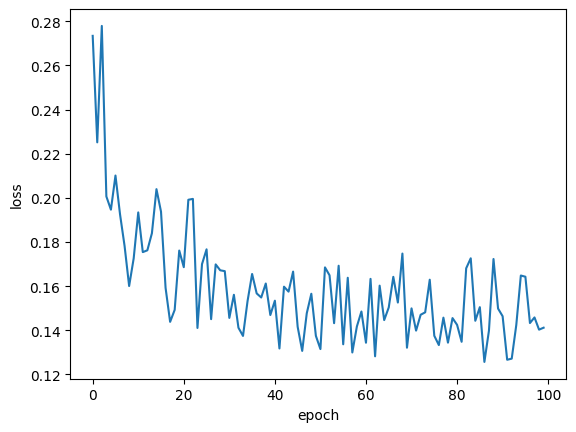

In [20]:
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')

# Sampling from the trained model

Now you can see the power of likelihood-based models. We can sample as many data points or images as we want from our trained model. Using the following helper function we can visualize generated bikes.

In [19]:
########################################
#########  !!!! IMPORTANT !!!!
######### Please run this block only once
######### If you face device any issue rerun the notebook
###########################################


def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t)
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    Applies noise to this image, if we are not in the last step yet.
    """
    # Define beta schedule
    T = 100

    betas = torch.linspace(.0001, .02, T).to(device)

    # Pre-calculate different terms for closed form
    alphas = 1. - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0)
    alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
    sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
    posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image():
    T = 100
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Sample noise
    img = torch.randn((1, 1, 30, 65), device=device)
    plt.figure(figsize=(40,5))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T):
        t = torch.full((1,), 0, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            plt.imshow(img[0][0].cpu().detach().numpy(), cmap='gray')

    plt.show()

# Sampling images from trained model

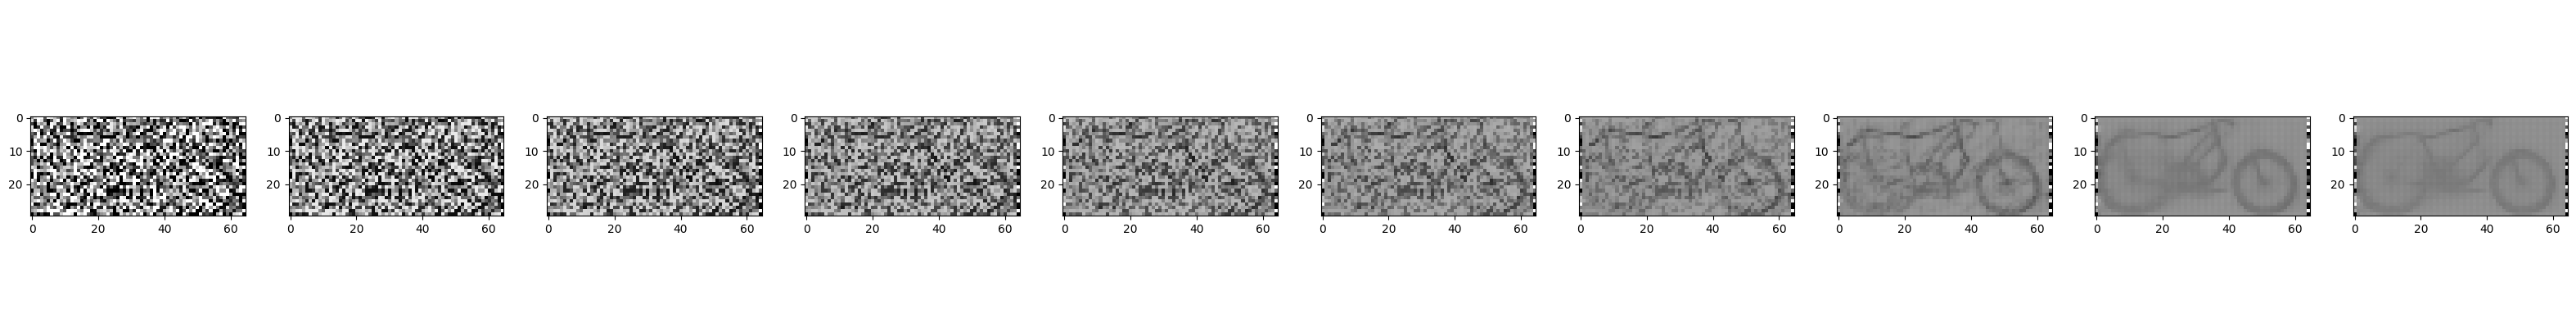

In [21]:
sample_plot_image()

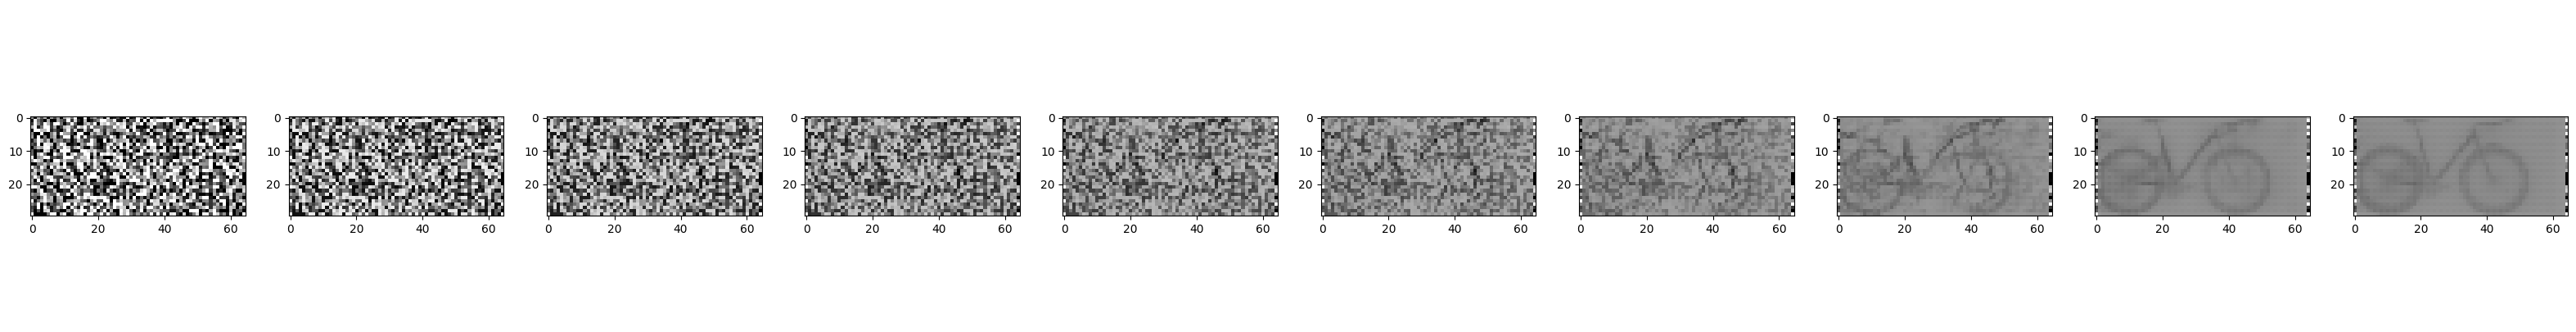

In [22]:
sample_plot_image()

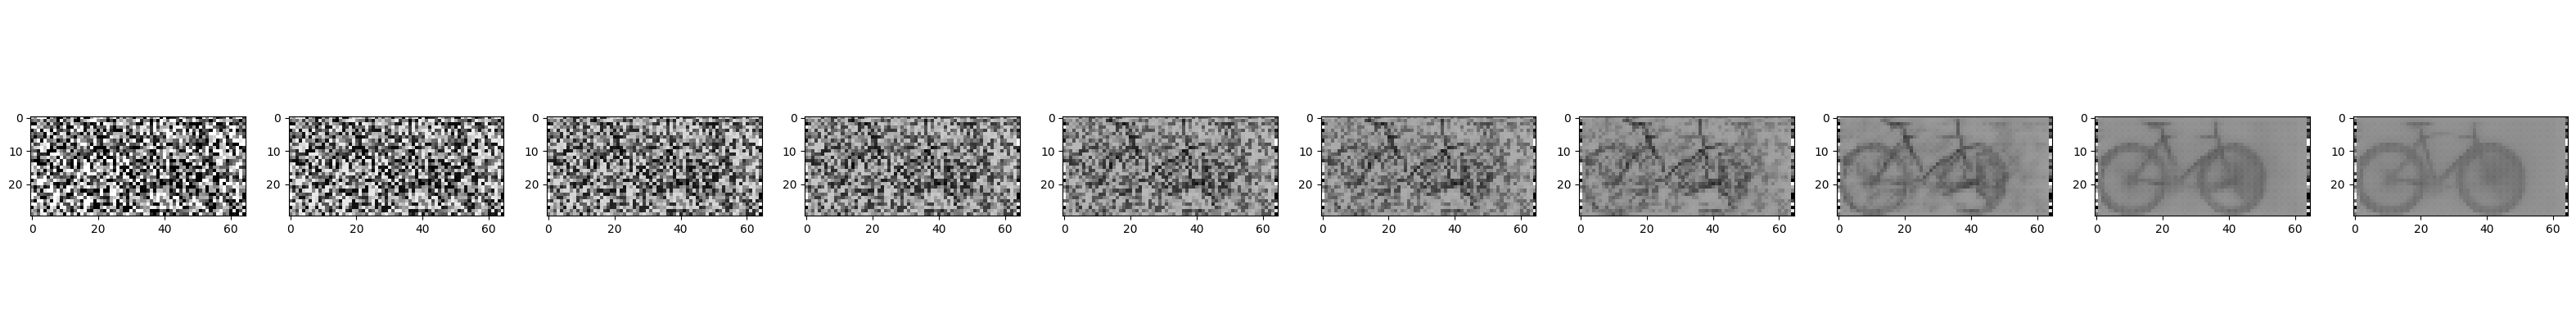

In [23]:
sample_plot_image()

These are obviously not the highest quality images, but we have trained the model very little and we are limited by compute here. Models like Dall-E and Stable Diffusion use this kind of model to generate the high quality images you see when using chatGPT or other text to image tools.

# **Part 1 Reflection Questions**

## 1.

Sampling a random vector in the latent space and decoding it into a sample may not be the best approach for generating new data. Can you think of a few different ways to get data that is more likely to be high quality? Other than completely new data generation what other ways can you think of for using the VAE?

### Reflection

If two points in the latent space are known to be high-quality (for example two known designs from input data), you can find what the model thinks is between those two points/designs using linear interpolation. This should be more likely to produce high-quality data.

Some additional uses of VAEs covered in class are for denoising and compression of data. Additionally VAEs can be used for anomoly detection.


## 2.

Diffusion models can generate very high quality data if trained well, however, we may be interested in encoding more than just the data disribution. One way to use generative models is to perform conditional generation. In the original DDPM [paper](https://arxiv.org/abs/2006.11239) the authors explore this. When you train a conditional DDPM, you include extra information about a design (a class or performance label, for example) so that this extra information enables learning the conditional distribution of data on these labels. Can you think of a few ways this can be useful in engineering design tasks?

### Reflection

With this sort of generation, you can essentially structure your exploration of the design space. The parameters with which the conditional DDPM can be used as a sort of "prompt" to target certaint attributes to generate toward. (This is especially useful in engineering and design uses, because usually these activities target specific attributes or outcomes.)


## 3.

Training diffusion models on very high resolution images maybe to costly and for the most part impractical. Can you think of ways to overcome this? Is there any synergies between latent generative models like VAEs and sequential denoising models like diffusion models that can help combine the quality and scalability of each approach? Hint: Look into how stable diffusion was built!

### Reflection

In question 1 I discussed how VAEs can be used to for compression and decompression. VAEs can be used to effectively compress or decompress images for use with diffusion. For example, the VAE compresses data as training inputs and outputs for a diffusion model. At runtime, the inputs and outputs can be compressed using the same VAE. This means that the diffusion process can run on much less information!